In [1]:
!pip install tweepy --quiet

In [2]:
import os
import numpy as np
import tweepy as tw
import pandas as pd
import json
import datetime as dt
from datetime import datetime, timedelta
#import wandb
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

BEARER_TOKEN = user_secrets.get_secret("BEARER_TOKEN")

In [4]:
client = tw.Client(bearer_token=BEARER_TOKEN)


# Queries info: https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md

# -is:retweet means I don"t want retweets
# lang:en is asking for the tweets to be in english
query = "chatgpt OR #chatgpt OR gpt4 OR gpt3 -giveaway -btc -bitcoin -coin -crypto -is:retweet"

def search_tweets(query=query, start_time=None, end_time=None, max_results=100):
    tweets = client.search_recent_tweets(query=query, 
                                         start_time=start_time,
                                         end_time=end_time,
                                         tweet_fields=[
                                             "context_annotations", 
                                             "created_at",
                                             "author_id",
                                             "public_metrics",
                                             "referenced_tweets",
                                             "possibly_sensitive",
                                             "source",
                                             "lang",
                                             "entities",
                                         ], 
                                         user_fields=[
                                             "id",
                                             "name",
                                             "username",
                                             "created_at",
                                             "description",
                                             "location",
                                             "public_metrics",
                                             "verified",
                                             "profile_image_url"
                                         ],
                                         expansions="author_id",
                                         max_results=max_results)
    
    return tweets


tweets = search_tweets(max_results=10)


# What context_annotations are: 
# https://developer.twitter.com/en/docs/twitter-api/annotations/overview
# (not using them for now)

for tweet in tweets.data[:1]:
    print(tweet.text)
    if len(tweet.context_annotations) > 0:
        print(tweet.context_annotations)

RT @jhonatan9902_g: There's a fine line between. 1/2 ChatGPT账号 
#ChatGPT账号 https://t.co/epfEzDgqvp
[{'domain': {'id': '46', 'name': 'Business Taxonomy', 'description': 'Categories within Brand Verticals that narrow down the scope of Brands'}, 'entity': {'id': '1557697333571112960', 'name': 'Technology Business', 'description': 'Brands, companies, advertisers and every non-person handle with the profit intent related to softwares, apps, communication equipments, hardwares'}}, {'domain': {'id': '47', 'name': 'Brand', 'description': 'Brands and Companies'}, 'entity': {'id': '1631434932688920576', 'name': 'OpenAI'}}, {'domain': {'id': '48', 'name': 'Product', 'description': 'Products created by Brands.  Examples: Ford Explorer, Apple iPhone.'}, 'entity': {'id': '1620189216029163524', 'name': 'ChatGPT'}}, {'domain': {'id': '131', 'name': 'Unified Twitter Taxonomy', 'description': 'A taxonomy of user interests. '}, 'entity': {'id': '848920371311001600', 'name': 'Technology', 'description': '

In [5]:
print(tweets.includes["users"][0].id)
print(tweets.includes["users"][0].created_at)
print(tweets.includes["users"][0].username)
print(tweets.includes["users"][0].name)
print(tweets.includes["users"][0].location)
print(tweets.includes["users"][0].verified)
print(tweets.includes["users"][0].public_metrics)
print(tweets.includes["users"][0].profile_image_url)

1531108808344453125
2022-05-30 03:04:51+00:00
iirrizzztl5gafc
ChatGPT账号批发/Chatgpt plus/Chatgpt注册/new bing
None
False
{'followers_count': 45, 'following_count': 73, 'tweet_count': 1122, 'listed_count': 0}
https://pbs.twimg.com/profile_images/1635623646374019073/g9anYwKj_normal.jpg


In [6]:
tweets.data[0].public_metrics

{'retweet_count': 4,
 'reply_count': 0,
 'like_count': 0,
 'quote_count': 0,
 'impression_count': 0}

In [7]:
tweets.data[0].entities

{'mentions': [{'start': 3,
   'end': 18,
   'username': 'jhonatan9902_g',
   'id': '2666640541'}],
 'urls': [{'start': 75,
   'end': 98,
   'url': 'https://t.co/epfEzDgqvp',
   'expanded_url': 'https://twitter.com/jhonatan9902_g/status/1657843061072830464/photo/1',
   'display_url': 'pic.twitter.com/epfEzDgqvp',
   'media_key': '3_1657842994102296576'}],
 'hashtags': [{'start': 64, 'end': 74, 'tag': 'ChatGPT账号'}],
 'annotations': [{'start': 53,
   'end': 59,
   'probability': 0.7848,
   'type': 'Other',
   'normalized_text': 'ChatGPT'},
  {'start': 65,
   'end': 71,
   'probability': 0.4638,
   'type': 'Other',
   'normalized_text': 'ChatGPT'}]}

In [8]:
dt_today = datetime.combine(datetime.today(), dt.time(0, 0, 0))
print(f"We will collect up to 100 x 24 tweets \nFrom:\t{dt_today - timedelta(days=1, hours=24)} \nTo:\t{dt_today - timedelta(days=1, hours=0)}")

We will collect up to 100 x 24 tweets 
From:	2023-05-12 00:00:00 
To:	2023-05-13 00:00:00


In [9]:
# Defining the extraction pipeline, it will go through each hour from the day before the previous day and will extract up to 100 tweets. 
# Then they are filtered and loaded into a temp DataFrame in order to only pick 1000 of them at the end randomly.

def build_raw_dataframe(days_ago=1):
    tweets_df = pd.DataFrame()
    
    # Extracting 200 tweets for each hour between 24 and 48 hours ago
    for h in range(24, 0, -1):
        start_time = dt_today - timedelta(days=days_ago, hours=h)
        end_time = dt_today - timedelta(days=days_ago, hours=h-1)
        
        hour_tweets = search_tweets(start_time=start_time, end_time=end_time, max_results=100)
        curr_dt = datetime.now()
        
        for tweet, user in zip(hour_tweets.data, hour_tweets.includes["users"]):

            # Keeping away from sensitive content :)
            if tweet.possibly_sensitive:
                continue
                
            # Exclude users with default profile images
            if user.profile_image_url.endswith('default_profile_normal.png'):
                continue
                
            if tweet.entities:
                # Check content of the tweet
                max_hashtags = 5
                max_mentions = 5
                max_urls = 3
                
                hashtags = tweet.entities.get('hashtags') or []
                mentions = tweet.entities.get('mentions') or []
                urls = tweet.entities.get('urls') or []

                if (len(hashtags) > max_hashtags or len(mentions) > max_mentions or len(urls) > max_urls):
                    continue
                    
                if hashtags:
                    hashtags = [hashtag["tag"] for hashtag in hashtags]
                else:
                    hashtags = []

            tweets_df = tweets_df.append(pd.DataFrame({"tweet_id": tweet.id,
                                                       "tweet_created": tweet.created_at,
                                                       "tweet_extracted": curr_dt,
                                                       "text": tweet.text,
                                                       "lang": tweet.lang,
                                                       "user_id": user.id,
                                                       "user_name": user.name, 
                                                       "user_username": user.username,
                                                       "user_location": user.location,
                                                       "user_description": user.description,
                                                       "user_created": user.created_at,
                                                       "user_followers_count": user.public_metrics["followers_count"],
                                                       "user_following_count": user.public_metrics["following_count"],
                                                       "user_tweet_count": user.public_metrics["tweet_count"],
                                                       "user_verified": user.verified,
                                                       #"hashtags": hashtags if tweet.entities else [],
                                                       "source": tweet.source,
                                                       "retweet_count": tweet.public_metrics["retweet_count"],
                                                       "like_count": tweet.public_metrics["like_count"],
                                                       "reply_count": tweet.public_metrics["reply_count"],
                                                       "impression_count": tweet.public_metrics["impression_count"],
                                                       #"is_retweet": tweet.retweeted,
                                                      }, 
                                                        index=[0])
                                    )
    return tweets_df

In [10]:
last_day_df = build_raw_dataframe()
n_sample = 1000 if len(last_day_df) > 1000 else len(last_day_df)
last_day_df = last_day_df.sample(n=n_sample)

print(last_day_df.shape)
last_day_df.head()

(1000, 20)


,tweet_id,tweet_created,tweet_extracted,text,lang,user_id,user_name,user_username,user_location,user_description,user_created,user_followers_count,user_following_count,user_tweet_count,user_verified,source,retweet_count,like_count,reply_count,impression_count
0,1657143437387235330,2023-05-12 21:59:18+00:00,2023-05-14 20:23:23.672531,RT @itsPaulAi: ChatGPT has now a big problem.\...,en,2932103068,Miguel Rodríguez,miguelmecro27,Colombia,🏍️ Biker... 💯% humano... Vendedor de cazerolas...,2014-12-19 14:16:13+00:00,138,391,3287,False,None,13521,0,0,0
0,1656886736763637760,2023-05-12 04:59:16+00:00,2023-05-14 20:23:03.579649,"RT @HadiIrem: chatgpt, Twitter, Apple ID and o...",en,1213261503031209985,🐢,posamkid,None,#MAYVARMY,2020-01-04 00:51:07+00:00,27,379,4530,False,None,14,0,0,0
0,1656947229347942400,2023-05-12 08:59:38+00:00,2023-05-14 20:23:07.912692,Claude くんを slack にいれて一通りあそんだけど、ChatGPT くんよりも親し...,ja,14867458,溝口 浩二 coji💿,techtalkjp,None,"プログラマー。数人規模で作られてるめっちゃ便利なものが好き。remix, playwrigh...",2008-05-22 12:02:30+00:00,562,674,1243,False,None,3,7,2,621
0,1656962344273186818,2023-05-12 09:59:42+00:00,2023-05-14 20:23:09.039324,"RT @Aulia_Mayya: chatgpt, Twitter, Apple ID an...",en,2262736622,Chatgpt账号注册/推特账号/newbing/Chatgpt账号批发/Chatgptplus,Anggraeninas,Bogor,全网最低价，自助下单：https://t.co/lirgIcMUAo售后qq：2592563834,2013-12-26 11:41:06+00:00,95,199,3007,False,None,15,0,0,0
0,1657098289102086179,2023-05-12 18:59:54+00:00,2023-05-14 20:23:19.635360,RT @Adri_365: O que é o chatgpt comparado ao S...,pt,1364258176049295360,Júlia Maria,mariaju289,"Lami, Porto Alegre",,2021-02-23 16:58:05+00:00,161,158,438,False,None,17,0,0,0


In [11]:
input_file_path = "/kaggle/input/chatgpt-1000-daily-tweets/chatgpt_daily_tweets.csv"
output_file_path = "/kaggle/working/chatgpt_daily_tweets.csv"

# Loading previous dataset
old_days_df = pd.read_csv(input_file_path)

# Concatenating all previous tweets with the new ones from the last day
all_days_df = pd.concat([old_days_df, last_day_df], axis=0)

# Sanity check
all_days_df = all_days_df[all_days_df.tweet_id.notna()]

# This will be the new file updated into the dataset
all_days_df.to_csv(output_file_path, index=False)

In [12]:
all_days_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43003 entries, 0 to 0
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tweet_id              43003 non-null  object 
 1   tweet_created         43003 non-null  object 
 2   tweet_extracted       43003 non-null  object 
 3   text                  43003 non-null  object 
 4   lang                  43003 non-null  object 
 5   user_id               43003 non-null  object 
 6   user_name             42998 non-null  object 
 7   user_username         43003 non-null  object 
 8   user_location         25448 non-null  object 
 9   user_description      36575 non-null  object 
 10  user_created          42998 non-null  object 
 11  user_followers_count  42995 non-null  float64
 12  user_following_count  42995 non-null  float64
 13  user_tweet_count      42995 non-null  float64
 14  user_verified         42995 non-null  object 
 15  source                0

In [13]:
all_days_df.shape

(43003, 20)

In [14]:
pd.to_datetime(all_days_df.tweet_created, utc=True).min(), pd.to_datetime(all_days_df.tweet_created, utc=True).max()

(Timestamp('2011-02-28 04:00:30+0000', tz='UTC'),
 Timestamp('2023-05-12 23:59:59+0000', tz='UTC'))

<AxesSubplot:title={'center':'Num. of Tweets for each Language, Total: 43003'}>

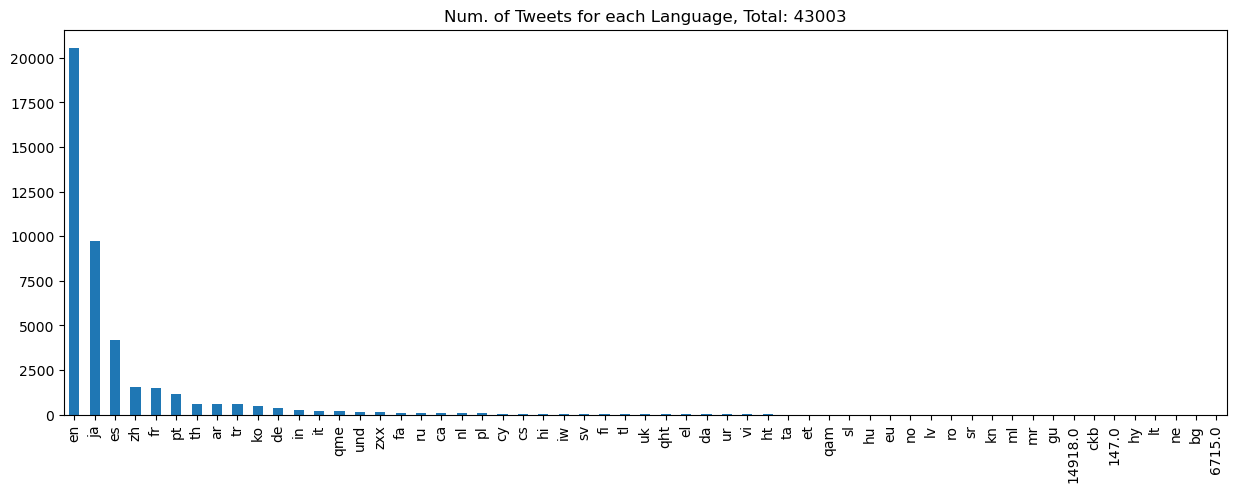

In [15]:
all_days_df.lang.value_counts().plot(kind="bar", figsize=(15, 5), title=f"Num. of Tweets for each Language, Total: {len(all_days_df)}")